In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from skimage import io

In [2]:
def crop_wing_from_image(image, output_path="", padding=20):
    h, w = image.shape[:2]
    crop_h = int(0.05 * h)
    crop_w = int(0.05 * w)
    image = image[crop_h : h - crop_h, crop_w : w - crop_w, :]

    # 复制一份原始图像用于最终裁切
    original_image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 可选：进行形态学操作去噪
    # 如果二值化后有一些小白点噪声，可以用开运算去除
    kernel = np.ones((3, 3), np.uint8)
    thresh_cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # 4. 轮廓发现
    # cv2.RETR_EXTERNAL: 只检测最外层的轮廓
    # cv2.CHAIN_APPROX_SIMPLE: 压缩水平、垂直和对角线段，只保留其端点
    contours, hierarchy = cv2.findContours(
        thresh_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        print("未能在图像中找到任何轮廓。")
        return

    # 5. 找到最大的轮廓（我们假设最大的轮廓就是果蝇翅膀）
    main_contour = max(contours, key=cv2.contourArea)

    # 6. 计算该轮廓的边界框
    x, y, w, h = cv2.boundingRect(main_contour)

    # --- 裁切步骤 ---
    # 7. 根据边界框坐标和 padding 进行裁切
    # 计算带边距的坐标，并确保它们不会超出图像边界
    y_start = max(0, y - padding)
    y_end = min(original_image.shape[0], y + h + padding)
    x_start = max(0, x - padding)
    x_end = min(original_image.shape[1], x + w + padding)

    # 从原始彩色图像中裁切
    cropped_wing = original_image[y_start:y_end, x_start:x_end]

    if output_path:
        # 8. 保存裁切后的图像
        cv2.imwrite(output_path, cropped_wing)

    return cropped_wing

In [3]:
root_path = "./"
leica_20 = glob(f"{root_path}/20X_magnification_Leica/*.tif")
leica_40 = glob(f"{root_path}/40X_magnification_Leica/*.tif")
leica_20_df = pd.read_csv(f"{root_path}/Leica_2X_coords.tsv", sep="\t")
leica_40_df = pd.read_csv(f"{root_path}/Leica_4X_coords.tsv", sep="\t")
leica_20_df.head()

,genotype,sex,side,microscope,magnification,ID,dimensions,Scale,X1,Y1,...,Y44,X45,Y45,X46,Y46,X47,Y47,X48,Y48,CentroidSize
0,egfr,F,L,lei,2X,74,600x449,0.0099,-0.048441,-0.114308,...,0.068493,0.011276,0.059001,0.070517,0.044980,0.153212,0.062683,0.010501,-0.036785,5.019146
1,egfr,F,L,lei,2X,106,600x449,0.0099,-0.056116,-0.114483,...,0.066943,0.010867,0.058269,0.072218,0.045896,0.152636,0.067188,0.008222,-0.037180,5.183952
2,egfr,F,L,lei,2X,107,600x449,0.0099,-0.051348,-0.117101,...,0.067158,0.013180,0.058334,0.071784,0.045403,0.149358,0.066763,0.010799,-0.037469,5.119107
3,egfr,M,L,lei,2X,135,600x449,0.0099,-0.046162,-0.116255,...,0.068556,0.012223,0.058840,0.072891,0.044702,0.152664,0.066701,0.008366,-0.037838,4.674828
4,mam,F,L,lei,2X,85,600x449,0.0099,-0.042267,-0.117507,...,0.068564,0.015603,0.057979,0.075875,0.044301,0.151017,0.064528,0.012658,-0.035440,4.449414


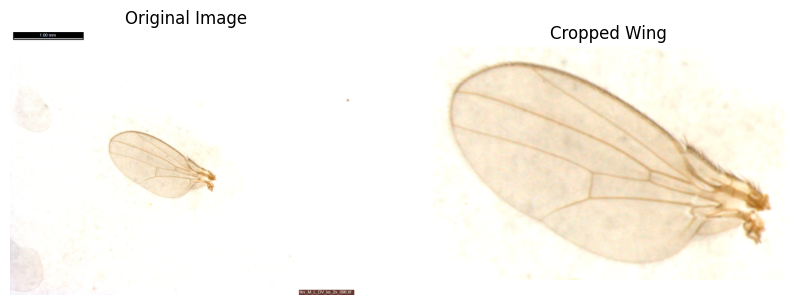

In [ ]:
test_img = io.imread(leica_20[0])
cropped_img = crop_wing_from_image(test_img, output_path='test_cropped_wing.jpg', padding=20)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(test_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Cropped Wing")
plt.imshow(cropped_img)A
plt.axis('off')
plt.show()